In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from tensorflow import keras 
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.mobilenet import preprocess_input
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from tensorflow.keras.applications.vgg19 import VGG19
print("Num of GPUs available: ", len(tf.test.gpu_device_name()))
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

2.9.1
Num of GPUs available:  13


2022-05-26 13:22:53.613542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 13:22:53.613829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 13:22:53.614030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 13:22:53.614278: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-26 13:22:53.614479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [22]:
datagen = ImageDataGenerator()

Path = "/home/atik/Documents/Summer_1/data/"
train_generator = datagen.flow_from_directory(
    directory=Path+"/train/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_generator = datagen.flow_from_directory(
    directory=Path+"/val/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
counter = Counter(train_generator.classes)
img, _ = train_generator.next()
img = np.array(img[0])
shape = np.shape(img)
#print(Counter(val_generator.classes).items())

Found 25600 images belonging to 256 classes.
Found 5120 images belonging to 256 classes.


# Model

In [39]:
model = VGG19(weights=None, include_top=True,
              input_shape=shape, classes=len(counter)) # None if randomly initialized wieghts
model.count_params()

140619072

# Training

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), 
    loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy']
)

In [41]:
model.fit(
    train_generator, 
    steps_per_epoch=400, epochs=30, verbose=1,
    callbacks=[
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, epsilon=0.007),
        EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.01)
    ],
    validation_data=val_generator, validation_steps=80, workers=4
)

Epoch 1/30
400/400 [==============================] - 111s 276ms/step - loss: 5.5453 - accuracy: 0.0041 - top_k_categorical_accuracy: 0.0185 - val_loss: 5.5355 - val_accuracy: 0.0043 - val_top_k_categorical_accuracy: 0.0248 - lr: 0.0100
Epoch 2/30
400/400 [==============================] - 111s 277ms/step - loss: 5.5425 - accuracy: 0.0036 - top_k_categorical_accuracy: 0.0182 - val_loss: 5.5452 - val_accuracy: 0.0039 - val_top_k_categorical_accuracy: 0.0195 - lr: 0.0100
Epoch 3/30
400/400 [==============================] - 111s 278ms/step - loss: 5.5441 - accuracy: 0.0033 - top_k_categorical_accuracy: 0.0169 - val_loss: 5.5452 - val_accuracy: 0.0039 - val_top_k_categorical_accuracy: 0.0193 - lr: 0.0100
Epoch 4/30
400/400 [==============================] - 112s 280ms/step - loss: 5.5461 - accuracy: 0.0036 - top_k_categorical_accuracy: 0.0164 - val_loss: 5.5374 - val_accuracy: 0.0080 - val_top_k_categorical_accuracy: 0.0307 - lr: 0.0100
Epoch 5/30
400/400 [==============================] 

# Loss/epoch plots

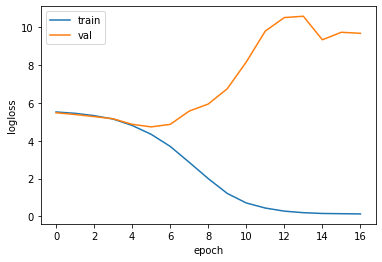

In [14]:
plt.plot(model.history.history['loss'], label='train');
plt.plot(model.history.history['val_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');

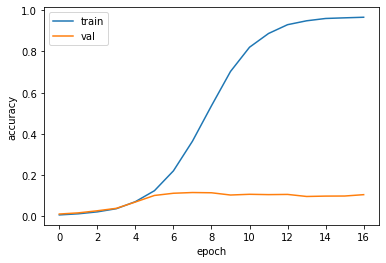

In [15]:
plt.plot(model.history.history['accuracy'], label='train');
plt.plot(model.history.history['val_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

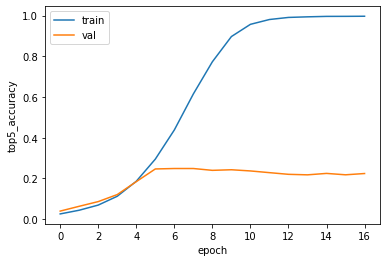

In [16]:
plt.plot(model.history.history['top_k_categorical_accuracy'], label='train');
plt.plot(model.history.history['val_top_k_categorical_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

In [17]:
model.evaluate_generator(val_generator, 80)

[9.674962997436523, 0.10390625149011612, 0.22402343153953552]